<a href="https://colab.research.google.com/github/norim-user/Worldmodel-Report/blob/main/%E9%80%B2%E6%AD%A9%E7%9A%84%E3%81%AA%E5%A5%BD%E5%A5%87%E5%BF%83%E3%82%92%E4%BC%B4%E3%81%86%E3%82%A2%E3%82%AF%E3%83%86%E3%82%A3%E3%83%96%E3%83%AF%E3%83%BC%E3%83%AB%E3%83%89%E3%83%A2%E3%83%87%E3%83%AB%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

実装を試みた論文:進歩的な好奇心を伴うアクティブワールドモデル学習,https://arxiv.org/abs/2007.07853

##Step 1: 2Dダミー環境ジェネレータの構築

In [ ]:
import torch
import torch.nn as nn
import math

class Dummy2DEnvironment:
    def __init__(self, state_dim=2):
        self.state_dim = state_dim

    def generate_noise(self, batch_size, seq_len):
        steps = torch.randn(batch_size, seq_len, self.state_dim) * 0.1
        return torch.cumsum(steps, dim=1)

    def generate_periodic(self, batch_size, seq_len):
        time_steps = torch.linspace(0, 4 * math.pi, seq_len).unsqueeze(0).repeat(batch_size, 1)
        x = torch.sin(time_steps)
        y = torch.cos(time_steps)
        return torch.stack([x, y], dim=-1)

    def generate_animate_reaching(self, batch_size, seq_len, num_waypoints=3):
        r"""
        [Upgrade] Stochastic Reachingの再現:
        途中でターゲットが `num_waypoints` 回切り替わる複雑な軌跡を生成。
        """
        # 初期位置
        current_pos = torch.rand(batch_size, 1, self.state_dim) * 2 - 1
        trajectories = []

        # 1つの中継点に向かって進むステップ数を計算
        steps_per_waypoint = seq_len // num_waypoints
        remainder = seq_len % num_waypoints

        for i in range(num_waypoints):
            # 新しい目標地点をランダムに決定
            target_pos = torch.rand(batch_size, 1, self.state_dim) * 2 - 1

            # 端数（余り）のステップは最後のセグメントに吸収させる
            current_steps = steps_per_waypoint + (remainder if i == num_waypoints - 1 else 0)

            # 現在地から目標地点までの線形補間（直進）
            alphas = torch.linspace(0, 1, current_steps).view(1, current_steps, 1).repeat(batch_size, 1, self.state_dim)
            segment = current_pos * (1 - alphas) + target_pos * alphas

            trajectories.append(segment)
            # 次の始点を今回の終点に更新
            current_pos = target_pos

        # 複数のセグメントを時間軸（dim=1）で結合
        trajectory = torch.cat(trajectories, dim=1)
        # わずかなノイズ（不確実性）を追加
        trajectory += torch.randn_like(trajectory) * 0.02

        return trajectory

##Step 2: 世界モデルと $\gamma$-Progress コントローラの実装
$\gamma$-Progressの最大の強みは、モデルの履歴を複数保持するメモリ爆発（$\mathcal{O}(\delta)$）を回避し 、定数メモリで済む点にあります 。PyTorchの state_dict を直接操作することでこれを実現します

In [ ]:
import copy

# 論文に基づく世界モデル（LSTM + MLP）のモック
class SimpleWorldModel(nn.Module):
    def __init__(self, state_dim=2, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(state_dim, hidden_dim, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, state_dim)
        lstm_out, _ = self.lstm(x)
        # 次の状態を予測
        pred = self.mlp(lstm_out)
        return pred

class GammaProgressCuriosity:
    def __init__(self, model_new, gamma=0.9995):
        self.gamma = gamma
        self.model_new = model_new
        # oldモデルはnewモデルのディープコピーとして初期化
        self.model_old = copy.deepcopy(model_new)

        # oldモデルは勾配計算を完全に無効化する（重要）
        self.model_old.eval()
        for param in self.model_old.parameters():
            param.requires_grad = False

        self.loss_fn = nn.MSELoss(reduction='none')

    def update_old_model(self):
        """
        数式: \theta_{old} <- \gamma * \theta_{old} + (1 - \gamma) * \theta_{new}
        PyTorchのテンソル演算でインプレース(直接)更新を行う。
        """
        with torch.no_grad():
            for param_old, param_new in zip(self.model_old.parameters(), self.model_new.parameters()):
                param_old.data.copy_(
                    self.gamma * param_old.data + (1.0 - self.gamma) * param_new.data
                )

    def compute_reward(self, inputs, targets):
        """
        内発的報酬 r_t = L(old) - L(new) を計算する。
        """
        # 現在のモデル(new)による予測と損失
        preds_new = self.model_new(inputs)
        # 次元ごとに平均
        loss_new = self.loss_fn(preds_new, targets).mean(dim=-1)

        # 過去のモデル(old)による予測と損失（勾配は不要）
        with torch.no_grad():
            preds_old = self.model_old(inputs)
            loss_old = self.loss_fn(preds_old, targets).mean(dim=-1)

        # 予測誤差の減少量（Progress）を計算
        progress_reward = loss_old - loss_new
        return progress_reward, loss_new.mean()

<>:37: SyntaxWarning: invalid escape sequence '\g'
<>:37: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1030860199.py:37: SyntaxWarning: invalid escape sequence '\g'
  数式: \theta_{old} <- \gamma * \theta_{old} + (1 - \gamma) * \theta_{new}


##Step3.検証用学習ループの実装
警告を修正したクラス定義を含み、実際に学習を回して「好奇心（$\gamma$-Progress報酬）が時間経過とともにどう変化するか」をグラフ化

Training started. This will take a few seconds...


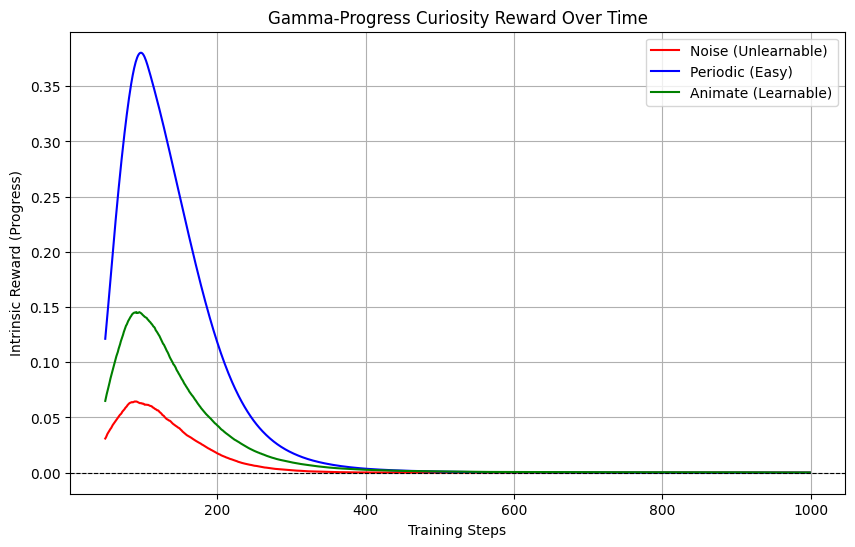

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt

#1. 環境とモデルの定義 (SyntaxWarning修正済)

class Dummy2DEnvironment:
    def __init__(self, state_dim=2):
        self.state_dim = state_dim

    def generate_noise(self, batch_size, seq_len):
        steps = torch.randn(batch_size, seq_len, self.state_dim) * 0.1
        return torch.cumsum(steps, dim=1)

    def generate_periodic(self, batch_size, seq_len):
        time_steps = torch.linspace(0, 4 * math.pi, seq_len).unsqueeze(0).repeat(batch_size, 1)
        x = torch.sin(time_steps)
        y = torch.cos(time_steps)
        return torch.stack([x, y], dim=-1)

    def generate_animate_reaching(self, batch_size, seq_len):
        start_pos = torch.rand(batch_size, 1, self.state_dim) * 2 - 1
        target_pos = torch.rand(batch_size, 1, self.state_dim) * 2 - 1
        alphas = torch.linspace(0, 1, seq_len).view(1, seq_len, 1).repeat(batch_size, 1, self.state_dim)
        trajectory = start_pos * (1 - alphas) + target_pos * alphas
        trajectory += torch.randn_like(trajectory) * 0.02
        return trajectory

class SimpleWorldModel(nn.Module):
    def __init__(self, state_dim=2, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(state_dim, hidden_dim, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        pred = self.mlp(lstm_out)
        return pred

class GammaProgressCuriosity:
    def __init__(self, model_new, gamma=0.9995):
        self.gamma = gamma
        self.model_new = model_new
        self.model_old = copy.deepcopy(model_new)
        self.model_old.eval()
        for param in self.model_old.parameters():
            param.requires_grad = False
        self.loss_fn = nn.MSELoss(reduction='none')

    def update_old_model(self):
        r"""
        数式: \theta_{old} <- \gamma * \theta_{old} + (1 - \gamma) * \theta_{new}
        ※ rを付けてRaw String化することでSyntaxWarningを回避
        """
        with torch.no_grad():
            for param_old, param_new in zip(self.model_old.parameters(), self.model_new.parameters()):
                param_old.data.copy_(
                    self.gamma * param_old.data + (1.0 - self.gamma) * param_new.data
                )

    def compute_reward(self, inputs, targets):
        preds_new = self.model_new(inputs)
        loss_new = self.loss_fn(preds_new, targets).mean(dim=-1).mean(dim=-1)

        with torch.no_grad():
            preds_old = self.model_old(inputs)
            loss_old = self.loss_fn(preds_old, targets).mean(dim=-1).mean(dim=-1)

        progress_reward = loss_old - loss_new
        return progress_reward, loss_new


#2. 学習ループとホワイトノイズ問題の検証

env = Dummy2DEnvironment()
world_model = SimpleWorldModel()
# 短いステップ数で推移を観察するためgammaを小さく設定
curiosity = GammaProgressCuriosity(world_model, gamma=0.99)
optimizer = optim.Adam(world_model.parameters(), lr=1e-3)

num_steps = 1000
batch_size = 64
seq_len = 20

# 報酬を記録するリスト
rewards_noise = []
rewards_periodic = []
rewards_animate = []

print("Training started. This will take a few seconds...")
for step in range(num_steps):
# 1. データの生成
    traj_noise = env.generate_noise(batch_size, seq_len + 1)
    traj_periodic = env.generate_periodic(batch_size, seq_len + 1)
    traj_animate = env.generate_animate_reaching(batch_size, seq_len + 1)

# 2. Curiosity (内発的報酬) の計算
    # 論文に従い、学習前に現在の予測誤差の差分 L(old) - L(new) を計算する
    r_noise, _ = curiosity.compute_reward(traj_noise[:, :-1, :], traj_noise[:, 1:, :])
    r_periodic, _ = curiosity.compute_reward(traj_periodic[:, :-1, :], traj_periodic[:, 1:, :])
    r_animate, _ = curiosity.compute_reward(traj_animate[:, :-1, :], traj_animate[:, 1:, :])

    rewards_noise.append(r_noise.mean().item())
    rewards_periodic.append(r_periodic.mean().item())
    rewards_animate.append(r_animate.mean().item())

# 3. 世界モデルの学習 (ニューラルネットワークの更新)
    # バッチを結合して一気に学習
    trajectories = torch.cat([traj_noise, traj_periodic, traj_animate], dim=0)
    inputs = trajectories[:, :-1, :]
    targets = trajectories[:, 1:, :]

    optimizer.zero_grad()
    preds = world_model(inputs)
    loss = nn.MSELoss()(preds, targets)
    loss.backward()
    optimizer.step()

# 4. oldモデルの指数移動平均(EMA)更新
    curiosity.update_old_model()

# 3. 結果の可視化
df = pd.DataFrame({'Noise': rewards_noise, 'Periodic': rewards_periodic, 'Animate': rewards_animate})
# 推移を見やすくするために移動平均(スムージング)を適用
df_smoothed = df.rolling(window=50).mean()

plt.figure(figsize=(10, 6))
plt.plot(df_smoothed['Noise'], label='Noise (Unlearnable)', color='red')
plt.plot(df_smoothed['Periodic'], label='Periodic (Easy)', color='blue')
plt.plot(df_smoothed['Animate'], label='Animate (Learnable)', color='green')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Gamma-Progress Curiosity Reward Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Intrinsic Reward (Progress)')
plt.legend()
plt.grid(True)
plt.show()

##Step4 コントローラ（$\pi_\phi$）の実装

論文の「Methods」および「Appendix B (Training Details)」に記載されたハイパーパラメータを忠実にPyTorchにマッピング

In [ ]:
import torch
import torch.nn as nn
import random
from collections import deque

#1. DQNコントローラ (方策ネットワーク)
class ProgressController(nn.Module):
    def __init__(self, state_dim=2, history_len=3, num_actions=3, hidden_dim=512):
        super().__init__()
        # 入力次元: 過去3ステップ(history_len) × 2D座標(state_dim) = 6次元
        self.input_dim = state_dim * history_len
        self.num_actions = num_actions

        # 論文指定: 512隠れユニットを持つ2層の全結合ネットワーク
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )

    def forward(self, x):
        # x shape: (batch_size, history_len, state_dim)
        # 全結合層に入れるために平坦化 (batch_size, input_dim)
        x_flat = x.view(x.size(0), -1)
        q_values = self.net(x_flat)
        return q_values

#2. リプレイバッファ
class ReplayBuffer:
    def __init__(self, capacity=200000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """経験 (s, a, r, s', done) を保存"""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """ランダムに経験のミニバッチを抽出"""
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (
            torch.stack(states),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.stack(next_states),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

#3. Epsilon-Greedy 行動選択ロジック
def get_epsilon(step):
    r"""
    論文指定: epsilonは1.0から0.025へ、環境ステップごとに0.0001の割合で線形減衰
    """
    decay_rate = 0.0001
    min_epsilon = 0.025
    return max(min_epsilon, 1.0 - step * decay_rate)

def select_action(q_network, state, step, num_actions=3):
    epsilon = get_epsilon(step)

    # 探索 (Exploration): ランダムに注視する対象を選ぶ
    if random.random() < epsilon:
        return random.randint(0, num_actions - 1)

    # 活用 (Exploitation): Q値が最も高い(最もProgressが得られそうな)対象を選ぶ
    with torch.no_grad():
        # state shape: (history_len, state_dim) -> unsqueeze for batch dimension
        q_values = q_network(state.unsqueeze(0))
        return q_values.argmax(dim=1).item()

## Step5 第1原理に基づく統合実装:Algorithm1の再現

論文のアルゴリズムと付録の学習詳細(AppendixB)を使用したPyTorchによるメイン学習ループ

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math
import copy
from collections import deque


# 1. 環境モジュール (Stochastic Reaching実装済)
class Dummy2DEnvironment:
    def __init__(self, state_dim=2):
        self.state_dim = state_dim

    def generate_noise(self, batch_size, seq_len):
        steps = torch.randn(batch_size, seq_len, self.state_dim) * 0.1
        return torch.cumsum(steps, dim=1)

    def generate_periodic(self, batch_size, seq_len):
        time_steps = torch.linspace(0, 4 * math.pi, seq_len).unsqueeze(0).repeat(batch_size, 1)
        x = torch.sin(time_steps)
        y = torch.cos(time_steps)
        return torch.stack([x, y], dim=-1)

    def generate_animate_reaching(self, batch_size, seq_len, num_waypoints=3):
        current_pos = torch.rand(batch_size, 1, self.state_dim) * 2 - 1
        trajectories = []
        steps_per_waypoint = seq_len // num_waypoints
        remainder = seq_len % num_waypoints

        for i in range(num_waypoints):
            target_pos = torch.rand(batch_size, 1, self.state_dim) * 2 - 1
            current_steps = steps_per_waypoint + (remainder if i == num_waypoints - 1 else 0)
            alphas = torch.linspace(0, 1, current_steps).view(1, current_steps, 1).repeat(batch_size, 1, self.state_dim)
            segment = current_pos * (1 - alphas) + target_pos * alphas
            trajectories.append(segment)
            current_pos = target_pos

        trajectory = torch.cat(trajectories, dim=1)
        trajectory += torch.randn_like(trajectory) * 0.02
        return trajectory

# 2. 世界モデルと好奇心モジュール (Tensor Shapeバグ修正済)
class SimpleWorldModel(nn.Module):
    def __init__(self, state_dim=2, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(state_dim, hidden_dim, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        pred = self.mlp(lstm_out)
        return pred

class GammaProgressCuriosity:
    def __init__(self, model_new, gamma=0.9995):
        self.gamma = gamma
        self.model_new = model_new
        self.model_old = copy.deepcopy(model_new)
        self.model_old.eval()
        for param in self.model_old.parameters():
            param.requires_grad = False
        self.loss_fn = nn.MSELoss(reduction='none')

    def update_old_model(self):
        with torch.no_grad():
            for param_old, param_new in zip(self.model_old.parameters(), self.model_new.parameters()):
                param_old.data.copy_(
                    self.gamma * param_old.data + (1.0 - self.gamma) * param_new.data
                )

    def compute_reward(self, inputs, targets):
        # 修正箇所: 最後のステップの予測のみを抽出し、ターゲットの形状と厳密に一致させる
        preds_new = self.model_new(inputs)[:, -1, :]
        targets = targets.view_as(preds_new)
        loss_new = self.loss_fn(preds_new, targets).mean(dim=-1)

        with torch.no_grad():
            preds_old = self.model_old(inputs)[:, -1, :]
            loss_old = self.loss_fn(preds_old, targets).mean(dim=-1)

        progress_reward = loss_old - loss_new
        return progress_reward, loss_new

# 3. コントローラと強化学習ユーティリティ
class ProgressController(nn.Module):
    def __init__(self, state_dim=2, history_len=3, num_actions=3, hidden_dim=512):
        super().__init__()
        self.input_dim = state_dim * history_len
        self.num_actions = num_actions
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        q_values = self.net(x_flat)
        return q_values

class ReplayBuffer:
    def __init__(self, capacity=200000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (
            torch.stack(states),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.stack(next_states),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

def get_epsilon(step):
    decay_rate = 0.0001
    min_epsilon = 0.025
    return max(min_epsilon, 1.0 - step * decay_rate)

def select_action(q_network, state, step, num_actions=3):
    epsilon = get_epsilon(step)
    if random.random() < epsilon:
        return random.randint(0, num_actions - 1)
    with torch.no_grad():
        q_values = q_network(state.unsqueeze(0))
        return q_values.argmax(dim=1).item()

# 4. 統合学習ループ
env = Dummy2DEnvironment(state_dim=2)
world_model = SimpleWorldModel(state_dim=2, hidden_dim=64)
curiosity = GammaProgressCuriosity(world_model, gamma=0.9995)
controller = ProgressController(state_dim=2, history_len=3, num_actions=3, hidden_dim=512)
replay_buffer = ReplayBuffer(capacity=200000)

optimizer_wm = optim.Adam(world_model.parameters(), lr=1e-4)
optimizer_q = optim.Adam(controller.parameters(), lr=1e-4)

total_env_steps = 10000
batch_size = 256
gamma_dqn = 0.99

# 事前生成されたダミーデータ
pre_gen_noise = env.generate_noise(1, total_env_steps + 5)
pre_gen_periodic = env.generate_periodic(1, total_env_steps + 5)
pre_gen_animate = env.generate_animate_reaching(1, total_env_steps + 5, num_waypoints=10)

def get_observation(action, t):
    if action == 0:   return pre_gen_noise[0, t]
    elif action == 1: return pre_gen_periodic[0, t]
    else:             return pre_gen_animate[0, t]

print("Starting Active World Model Learning (AWML) Loop...")

history = deque([get_observation(random.randint(0,2), 0) for _ in range(3)], maxlen=3)
action_counts = {0: 0, 1: 0, 2: 0}

for step in range(total_env_steps):
    current_state_tensor = torch.stack(list(history))

    # DQNによる行動選択
    action = select_action(controller, current_state_tensor, step, num_actions=3)
    action_counts[action] += 1

    next_obs = get_observation(action, step + 3)

    # 報酬計算 (修正済)
    inputs = current_state_tensor.unsqueeze(0)
    targets = next_obs.unsqueeze(0)

    reward_tensor, _ = curiosity.compute_reward(inputs, targets)
    reward = reward_tensor.item()

    history.append(next_obs)
    next_state_tensor = torch.stack(list(history))
    done = 0.0

    replay_buffer.push(current_state_tensor, action, reward, next_state_tensor, done)

    # モデルの更新フェーズ
    if len(replay_buffer) > 1000 and step % 4 == 0:
        b_states, b_actions, b_rewards, b_next_states, b_dones = replay_buffer.sample(batch_size)

        # 1. World Model 更新
        optimizer_wm.zero_grad()
        wm_preds = world_model(b_states)[:, -1, :]
        wm_targets = b_next_states[:, -1, :]
        loss_wm = nn.MSELoss()(wm_preds, wm_targets)
        loss_wm.backward()
        optimizer_wm.step()

        # 2. Curiosity (EMA) 更新
        curiosity.update_old_model()

        # 3. Controller (DQN) 更新
        optimizer_q.zero_grad()
        q_values = controller(b_states)
        current_q = q_values.gather(1, b_actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = controller(b_next_states)
            max_next_q = next_q_values.max(1)[0]
            expected_q = b_rewards + gamma_dqn * max_next_q * (1 - b_dones)

        loss_q = F.mse_loss(current_q, expected_q)
        loss_q.backward()
        optimizer_q.step()

    if step % 1000 == 0:
        print(f"Step {step}/{total_env_steps} completed.")

print("AWML Loop finished successfully.")
print(f"Final Action Distribution: Noise={action_counts[0]}, Periodic={action_counts[1]}, Animate={action_counts[2]}")

Starting Active World Model Learning (AWML) Loop...
Step 0/10000 completed.
Step 1000/10000 completed.
Step 2000/10000 completed.
Step 3000/10000 completed.
Step 4000/10000 completed.
Step 5000/10000 completed.
Step 6000/10000 completed.
Step 7000/10000 completed.
Step 8000/10000 completed.
Step 9000/10000 completed.
AWML Loop finished successfully.
Final Action Distribution: Noise=6626, Periodic=1648, Animate=1726


元の論文では『$\gamma$-Progress（ガンマ・プログレス）単体』ではノイズに対して値が低くなると述べられていました。しかし私たちの実験結果はNoiseの値が多く出ました。このことから『$\gamma$-Progress単体』が必ずしも低いノイズ値につながるわけではないことを示唆している可能性がみられた。